# COMP8325 Week 5 Workshop
# Anomaly Detection
* ## Demos for anomaly detection
* ## Task 1 Tuning the performance with respect to k (number of neighbors) for LOF
* ## Task 2 Tuning the performance with respect to sample size for iForest
* ## Task 3 (optional) Perform anomaly detection with One-Class SVM


## Demos

In [19]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

# Pre-processing
from sklearn import preprocessing

# Anomaly Detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


### Demo-1: K-means for anomaly detection

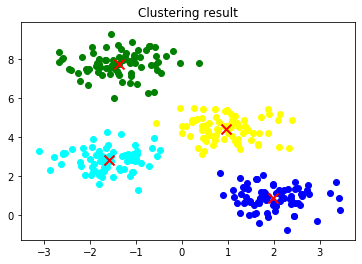


 Cluter center: 
 [[ 1.98258281  0.86771314]
 [ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [-1.58438467  2.83081263]]


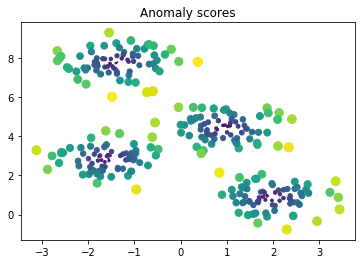

In [3]:
# We first show how clustering method KMeans introduced before can be used for anomaly detection with minor modification
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate an exmaple 2-dimensional datasets containing 4 clusters for a demo
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Create a K-means clustering model with k=4, and k-means++ as the intialization strategy
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)

# Perform clustering by fitting the model with the data
kmeans.fit(X)

# Predict the cluster for each data instance. This step can be combined with the last one by using kmeans.fit_predict(X)
y_pred = kmeans.predict(X)

# Visualize the cluster centers to explore how the clustering result looks like
colors = ['blue', 'yellow', 'green', 'cyan']
for i, color in enumerate(colors):
    plt.scatter(X[y_pred == i, 0], X[y_pred == i, 1], c=color)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', lw=2, c='red', s=100)
plt.title('Clustering result')
plt.show()
print('\n Cluter center: \n', kmeans.cluster_centers_)

# Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers.
# In this way, we could derive the anomaly scores from clustering

X_new=kmeans.transform(X)
scores=X_new.min(axis=1)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=scores, s=50*scores)
plt.title('Anomaly scores')
plt.show()

### Demo-2: LOF

In [5]:
# Load the data. Orignal data set has been processed (downsampled) to facilitate your data analysis. Anomaly label has been given. Only numerical attributes are used in this data set
raw_data = pd.read_csv("kdd99-0.01.csv")
print('\n data size: (%d, %d)\n' % raw_data.shape)

raw_data.head()


 data size: (14081, 39)



,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Label
0,0,256,1169,0,0,0,0,0,1,0,...,139,1.0,0.0,0.25,0.04,0.0,0.0,0.0,0.0,1
1,0,248,2129,0,0,0,0,0,1,0,...,255,1.0,0.0,0.04,0.03,0.0,0.0,0.0,0.0,1
2,0,212,1309,0,0,0,0,0,1,0,...,255,1.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0,1
3,0,217,18434,0,0,0,0,0,1,0,...,255,1.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0,1
4,0,290,460,0,0,0,0,0,1,0,...,255,1.0,0.0,0.04,0.05,0.0,0.0,0.0,0.0,1


In [6]:
# Question 1: How can we drop a specific column in the data from processing? 

# Specifying features and target attribute
X = raw_data.drop(['Label'], axis='columns') # Drop specified labels from rows or columns.

X.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38
0,0,256,1169,0,0,0,0,0,1,0,...,4,139,1.0,0.0,0.25,0.04,0.0,0.0,0.0,0.0
1,0,248,2129,0,0,0,0,0,1,0,...,23,255,1.0,0.0,0.04,0.03,0.0,0.0,0.0,0.0
2,0,212,1309,0,0,0,0,0,1,0,...,21,255,1.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0
3,0,217,18434,0,0,0,0,0,1,0,...,41,255,1.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0
4,0,290,460,0,0,0,0,0,1,0,...,23,255,1.0,0.0,0.04,0.05,0.0,0.0,0.0,0.0


In [7]:
# Question 2: How can we scale the numbers to given range for Anomly detection? 

# Transform features by scaling each feature to a given range.
# This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

scaler = preprocessing.MinMaxScaler()
X_data = X.values

X_scaled = scaler.fit_transform(X_data)
X = X_scaled

y = raw_data['Label'].values


In [8]:
# Question 3: What is Anomly rate? What does it tell us? 

# Anomaly rate. Assuming that the target attribute has '1' for normal instances, and '-1' for anomalies
print('\n Anomaly rate: %f \n' % (-1.0*(y-1).sum()/2.0/X.shape[0]))


 Anomaly rate: 0.038847 



In [10]:
# Question 4: How can we measure the local deviation of density of a given sample with respect to its neighbors?

# Unsupervised Outlier Detection using Local Outlier Factor (LOF)
# The anomaly score of each sample is called Local Outlier Factor. 
# Create the local outlier factor (LOF). Note here we need to set 'novelty' parameter as 'True' to get LOF scores
detector_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)

# Train the model (Compute the LOF scores)
detector_lof.fit(X)

# Obtain anomaly score (Note that this is not the yes/no prediction as we don't know the threshold)
y_score = detector_lof.decision_function(X)
print("LOF: \n", y_score)

LOF: 
 [0.19076799 0.50956163 0.5099336  ... 0.40971203 0.33866019 0.53182027]


In [11]:
# Question 5: What is Area Under Curve (AUC) and what information it conveys?

# Evaluate using AUC, the higher, the better
# AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
# Reference: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

auc = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % auc)

# Is AUC high enough? What does the lower value of AUC conveys?


 AUC score: 0.624942



In [12]:
# Predict the Yes/No label. The algorithm set a default threshold. But note that this is really data-dependent
y_pred = detector_lof.predict(X)
auc = roc_auc_score(y, y_pred)
print('\n AUC score: %f\n' % auc)


 AUC score: 0.578294



### Demo-3: iForest

In [13]:
# Create the iForest model
'''
Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings 
required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.
'''
detector_if = IsolationForest()



In [14]:
# Train the model
detector_if.fit(X)

# Obtain anomaly score (Note that this is not the yes/no prediction as we don't know the threshold)
y_score = detector_if.decision_function(X)
print(y_score)

[0.14005699 0.13884737 0.15820838 ... 0.12284352 0.1211039  0.13937216]


In [15]:
# Evaluate using AUC (Area Under Curve)
auc = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % auc)


 AUC score: 0.935317



In [16]:
# Predict the Yes/No label. The algorithm set a default threshold. But note that this is really data-dependent
y_pred = detector_if.predict(X)
print('\n AUC score: %f\n' % roc_auc_score(y, y_pred))


 AUC score: 0.824054



#### It can be seen that Isolation Forest has a very high performance.

### Demo-4 Statistical model

In [20]:
# Create the Robust covariance model
ee = EllipticEnvelope()

# Train the model
ee.fit(X)

# Obtain anomaly score (Note that this is not the yes/no prediction as we don't know the threshold) 
y_score = ee.decision_function(X)
print(y_score)

# Evaluate using AUC (Area Under Curve)
auc = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % auc)


/Users/mq20197379/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


[937087.6354759  983915.58950649 983910.23110111 ... 983819.46529857
 983835.79868629 983856.81348093]

 AUC score: 0.896835



In [21]:
# Predict the Yes/No label. The algorithm set a default threshold. But note that this is really data-dependent
y_pred = ee.predict(X)
print('\n AUC score: %f\n' % roc_auc_score(y, y_pred))


 AUC score: 0.675277



## Task 1

In [ ]:
# Task 1. Try different values of k ('n_neighbors' parameter) for LOF to identify a good one. 
# Plot the relationship for k changing from 5 to 50 with 5 as the step.

# Please refer to https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

# Computer the auc values for different k
auc_scores = []

# Plot the relationship between auc and k


## Task 2

In [ ]:
# Task 2 Try different sample size ('max_samples' parameter) for iforest to identify a good one. 
# Plot the relationship for the size from 2**5 to 2**14 with an exponential step 2**i.

# Computer the auc values for different sample size
auc_scores = []


# Plot the relationship between auc and sample size


## Task 3 (Optional)

In [ ]:
# Optional task: Perform anomaly detection with One-Class SVM (https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)

